In [1]:
import sys
#%cd variational_inference_for_longitudinal_data/
sys.path.append('diffusion/stable_diffusion/')
sys.path.append('diffusion/stable_diffusion/model/')
sys.path.append('lib/src/')
import torch
from torch import nn
import torch.nn.functional as F
import os
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
import logging




from diffusion.stable_diffusion.latent_diffusion import MyLatentDiffusion, LitLDM
from diffusion.stable_diffusion.model.unet import UNetModel
from diffusion.stable_diffusion.sampler.ddim import DDIMSampler

from lib.src.pythae.models import VAE
from lib.src.pythae.models import LLDM_IAF, LVAE_IAF_Config
from lib.src.pythae.trainers import BaseTrainerConfig, BaseTrainer
from lib.scripts.utils import Encoder_Chairs,Decoder_Chairs
from lib.scripts.utils import My_MaskedDataset, make_batched_masks
from lib.src.pythae.trainers.training_callbacks import WandbCallback


def load_config_unet(config):
    return UNetModel(
        in_channels=config['in_channels'],
        out_channels=config['out_channels'],
        channels=config['channels'],
        n_res_blocks=config['n_res_blocks'],
        attention_levels=config['attention_levels'],
        channel_multipliers=config['channel_multipliers'],
        n_heads=config['n_heads'],
    )


def plot_sequence(X):

    if len(X.shape) == 4:
        X = X.unsqueeze(0)

    X = X.cpu().detach().numpy()
    num_seq = X.shape[0]
    num_obs = X.shape[1]

    logger = logging.getLogger()
    old_level = logger.level
    logger.setLevel(100)
    plt.figure(figsize=(10, 10))
    for i in range(num_seq):
        for j in range(num_obs):
            plt.subplot(num_seq, num_obs, i*num_obs+j+1)
            plt.imshow(X[i, j].transpose(1, 2, 0))
            plt.axis('off')

    plt.show()
    logger.setLevel(old_level)


%reload_ext autoreload
%autoreload 2

!nvidia-smi

Mon Jul  1 15:42:02 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A2000 12GB          Off |   00000000:01:00.0 Off |                  Off |
| 30%   45C    P8             11W /   70W |    4075MiB /  12282MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
PATH_DATA = 'lib/my_data/sprites/Sprites_train.pt'


train_data = torch.load(os.path.join(PATH_DATA))[:-1000, :-1, :, :, :]
eval_data = torch.load(os.path.join(PATH_DATA), map_location="cpu")[-1000:, :-1, :, :, :]
#test_data = torch.load(os.path.join('lib/my_data/sprites/Sprites_test.pt'), map_location="cpu")

print(train_data.shape)
train_data = train_data.permute(0, 1, 4, 2, 3)
eval_data = eval_data.permute(0, 1, 4, 2, 3)
#test_data = test_data.permute(0, 1, 4, 2, 3)
print(train_data.shape)

train_seq_mask = torch.ones(train_data.shape[:2], requires_grad=False).type(torch.bool)
eval_seq_mask = torch.ones(eval_data.shape[:2], requires_grad=False).type(torch.bool)
#test_seq_mask = torch.ones(test_data.shape[:2], requires_grad=False).type(torch.bool)
train_pix_mask = torch.ones_like(train_data, requires_grad=False).type(torch.bool)
eval_pix_mask = torch.ones_like(eval_data, requires_grad=False).type(torch.bool)
#test_pix_mask = torch.ones_like(test_data, requires_grad=False).type(torch.bool)

train_dataset = My_MaskedDataset(train_data, train_seq_mask, train_pix_mask)
eval_dataset = My_MaskedDataset(eval_data, eval_seq_mask, eval_pix_mask)
#test_dataset = My_MaskedDataset(test_data, test_seq_mask, test_pix_mask)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=200, shuffle=True)
val_loader = torch.utils.data.DataLoader(eval_data, batch_size=200, shuffle=True)

torch.Size([8000, 7, 64, 64, 3])
torch.Size([8000, 7, 3, 64, 64])


In [4]:
# encoder = Encoder_Chairs(config)
# decoder = Decoder_Chairs(config)
# vae = LVAE_IAF(config, encoder, decoder)


PATH_VAE_FOLDER = 'pre-trained_vae/VAE_training_2024-06-16_15-12-03/final_model'
PATH_DIFFUSION_CKPT = 'ldm/lightning_logs/version_3/checkpoints/epoch=149-step=4800.ckpt'

# PATH_VAE_FOLDER = 'pre-trained_vae/VAE_training_2024-06-27_11-46-10/final_model'
# PATH_DIFFUSION_CKPT = 'ldm/lightning_logs/version_7/checkpoints/epoch=49-step=1600.ckpt'



device = 'cuda'
vae = VAE.load_from_folder(PATH_VAE_FOLDER).to(device)
vae.eval()
_, _, _ = vae.retrieveG(train_data, verbose = True, T_multiplier=1, device = device)


# in_channels = 3
# out_channels = 3
# channels = 32
# n_res_blocks = 2
# attention_levels = [2]
# channel_multipliers = (1, 2, 4)
# n_heads = 16


in_channels = 3
out_channels = 3
channels = 64
n_res_blocks = 4
attention_levels = [0]
channel_multipliers = [1]
n_heads = 4

unet_config = {
    'in_channels': in_channels,
    'out_channels': out_channels,
    'channels': channels,
    'n_res_blocks': n_res_blocks,
    'attention_levels': attention_levels,
    'channel_multipliers': channel_multipliers,
    'n_heads': n_heads,
}

unet = load_config_unet(unet_config)

latent_scaling_factor = 1
n_steps = 1000

#Pas oublier de modif
linear_start =  0.00085
linear_end = 0.012

input_dim = (3, 64, 64)
f = 32 #subsampling factor
latent_dim = 3* (64 // f) * (64 // f)
print('Latent dim:', latent_dim)


latent_diffusion = MyLatentDiffusion(unet, latent_scaling_factor, latent_dim, n_steps, linear_start, linear_end)
print('Number of parameters in the diffusion model: ', sum(p.numel() for p in latent_diffusion.parameters() if p.requires_grad))

model = LitLDM.load_from_checkpoint(PATH_DIFFUSION_CKPT, ldm = latent_diffusion, vae = vae, latent_dim = latent_dim, lr = 6e-4).to(device)
diffusion = model.ldm

Running Kmedoids


/users/eleves-a/2020/meilame.tayebjee/miniconda3/lib/python3.12/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 74 is empty! self.labels_[self.medoid_indices_[74]] may not be labeled with its corresponding cluster (74).
  warnings.warn(
/users/eleves-a/2020/meilame.tayebjee/miniconda3/lib/python3.12/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 82 is empty! self.labels_[self.medoid_indices_[82]] may not be labeled with its corresponding cluster (82).
  warnings.warn(
/users/eleves-a/2020/meilame.tayebjee/miniconda3/lib/python3.12/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 84 is empty! self.labels_[self.medoid_indices_[84]] may not be labeled with its corresponding cluster (84).
  warnings.warn(
/users/eleves-a/2020/meilame.tayebjee/miniconda3/lib/python3.12/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 106 is empty! self.labels_[self.medoid_indices_[106]] may not be 

Finding temperature
Best temperature found:  2.6089720726013184
Building metric
Increasing T by  1
Latent dim: 12
Number of parameters in the diffusion model:  2223043


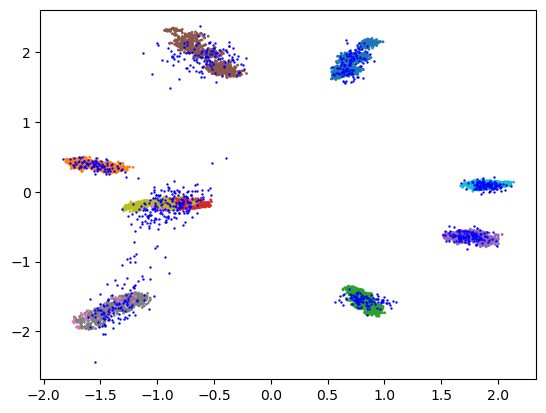

/tmp/ipykernel_159248/3445385557.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid = torch.cat([grid, torch.tensor(last_obs_embeddings)], dim=0)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


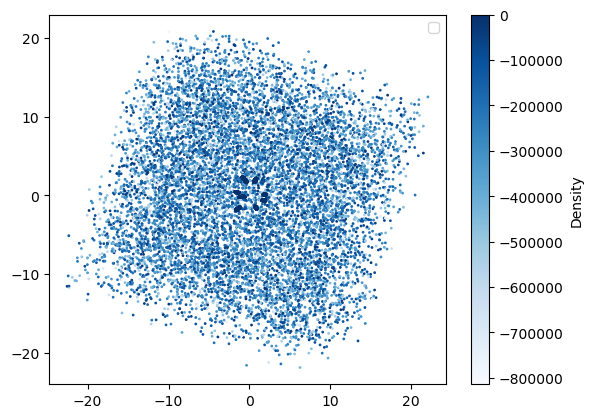

In [8]:
from sklearn.mixture import GaussianMixture

#########
NUM_CLUSTERS = 10
#########

last_obs_embeddings = vae.encoder.to('cpu')(train_dataset.data[:, -1, :, :, :]).embedding.cpu()
NUM_OBS = train_data.shape[1]
GM = GaussianMixture(n_components=NUM_CLUSTERS, covariance_type='diag')

GM.fit(last_obs_embeddings)

pca = PCA(n_components=2)

pca.fit(last_obs_embeddings)
last_obs_pca = pca.transform(last_obs_embeddings)

new_z = GM.sample(1000)[0]
torch.save(new_z, 'zT_samples.pt')
new_z_pca = pca.transform(new_z)

plt.scatter(last_obs_pca[:, 0], last_obs_pca[:, 1], c=GM.predict(last_obs_embeddings), cmap='tab10', s=1)
plt.scatter(new_z_pca[:, 0], new_z_pca[:, 1], c='blue', s=0.5)
plt.show()

scale = 30
grid = scale*torch.rand(10000, 12)- (scale//2)
grid = torch.cat([grid, torch.tensor(last_obs_embeddings)], dim=0)
train_loader = torch.utils.data.DataLoader(grid, batch_size=256, shuffle=False)
all_logdet_G_grid = []

for i, z in enumerate(train_loader):
    z = z.to(device)
    logdet_G = GM.score_samples(z.cpu().detach().numpy())
    all_logdet_G_grid.append(torch.tensor(logdet_G))

all_logdet_G_grid = torch.cat(all_logdet_G_grid).cpu().detach().numpy()
grid_pca = pca.transform(grid.detach().numpy())
plt.scatter(grid_pca[:, 0], grid_pca[:, 1], c=all_logdet_G_grid, cmap='Blues', s=1)

plt.legend()
plt.colorbar(label="Density")
plt.show()


In [49]:
model_config = LVAE_IAF_Config(
    input_dim=(3, 64, 64),
    n_obs_per_ind=train_data.shape[1], #8 for Sprites, 7 as we remove last obs
    latent_dim=latent_dim,
    beta=0.2,
    n_hidden_in_made=4,
    n_made_blocks=2,
    warmup=0,
    context_dim=None,
    prior='standard',
    posterior='iaf',
    linear_scheduling_steps=10,

)
training_config = BaseTrainerConfig(
        num_epochs=100,
        learning_rate=1e-4,
        batch_size=256,
        steps_saving=50,
        steps_predict=100,
        shuffle=True,
        output_dir='lldm'
    )


device = 'cuda'
encoder = Encoder_Chairs(model_config).to(device)
decoder = Decoder_Chairs(model_config).to(device)
ddim_sampler = DDIMSampler(diffusion, n_steps = train_data.shape[1]-1, ddim_eta = 1)
zT_samples = torch.load('zT_samples.pt') #shape (1000, 12)


#############
# lldm = LLDM_IAF(model_config=model_config, encoder=encoder, decoder=decoder, 
#                 pretrained_vae=vae, pretrained_ldm=diffusion, ddim_sampler=ddim_sampler,
#                 precomputed_zT_samples=zT_samples, GM = GM, verbose = True)

lldm = LLDM_IAF(model_config=model_config, encoder=encoder, decoder=decoder, 
                 pretrained_vae=vae, pretrained_ldm=diffusion, ddim_sampler=ddim_sampler,
                 precomputed_zT_samples=zT_samples, verbose = True)

Diffusion time steps  [997 831 665 499 333 167   1]
Running on  cuda:0
Freezing pre-trained VAE and pre-trained LDM...
Freezing done.
Number of trainable parameters: 1.8e+06
Number of total parameters: 5.1e+06


In [10]:
callbacks = [] # the TrainingPipeline expects a list of callbacks
wandb_cb = WandbCallback() # Build the callback 
# SetUp the callback 
wandb_cb.setup(
    training_config=training_config, # pass the training config
    model_config = model_config,
    project_name="LLDM_reborn", # specify your wandb project # specify your wandb entity
)
callbacks.append(wandb_cb) 

eval/epoch_loss,█▂▁█
train/epoch_loss,█▂▁▃
train/global_step,▁▃▆█
eval/epoch_loss,158.82389
train/epoch_loss,170.14004
train/global_step,4


In [52]:
optimizer = torch.optim.Adam(lldm.parameters(), lr=1e-3)

### Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=4, verbose=True)
trainer = BaseTrainer(
            model=lldm,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
            training_config=training_config,
            optimizer=optimizer,
            scheduler=scheduler,
            #callbacks=callbacks
        )

lldm.train()

LLDM_IAF(
  (decoder): Decoder_Chairs(
    (fc): Linear(in_features=12, out_features=2048, bias=True)
    (layers): Sequential(
      (0): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ResBlock(
        (conv_block): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (2): ResBlock(
        (conv_block): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (3): ResBlock(
        (conv_block): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
       

In [53]:
lldm.train()
trainer.train()

Model passed sanity check !

Created lldm/LLDM_IAF_training_2024-07-01_15-31-10. 
Training config, checkpoints and final model will be saved here.

Successfully launched training !



Training of epoch 1/100:   0%|          | 0/32 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0  267.302161  14.445782    5.0
1  258.506739  -1.979157    8.0
2  250.378586  -1.984296    7.0
3  255.230280  -1.984248   10.0
4  261.653325  -1.974906    6.0
5  251.993121  -1.966604   13.0
6  243.763055  -1.973454    5.0


Eval of epoch 1/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 232.3024
Eval loss: 168.1885
--------------------------------------------------------------------------


Training of epoch 2/100:   0%|          | 0/32 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0  154.441493  15.853161    3.0
1  162.215260  -1.966148    4.0
2  161.171039  -1.970561    5.0
3  159.770348  -1.983247    6.0
4  157.236259  -1.994622    6.0
5  160.934581  -1.962561    7.0
6  157.035782  -1.983167    5.0


Eval of epoch 2/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 158.0347
Eval loss: 151.7434
--------------------------------------------------------------------------


Training of epoch 3/100:   0%|          | 0/32 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0  149.070948  18.630233    6.0
1  149.356105  -2.000000    6.0
2  149.707502  -2.000000    8.0
3  149.590337  -2.000000    3.0
4  149.469121  -2.000000    3.0
5  151.309738  -2.000000    1.0
6  151.571121  -2.000000    9.0


Eval of epoch 3/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 149.8707
Eval loss: 148.0263
--------------------------------------------------------------------------


Training of epoch 4/100:   0%|          | 0/32 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0  147.663595  15.861167    6.0
1  145.605000  -1.968719    4.0
2  147.023083  -1.964297    5.0
3  148.325312  -1.962278    9.0
4  146.599113  -1.966985    4.0
5  147.781926  -1.968605    3.0
6  147.480304  -1.978160    5.0


Eval of epoch 4/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 147.3567
Eval loss: 145.6535
--------------------------------------------------------------------------


Training of epoch 5/100:   0%|          | 0/32 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0  147.008333  13.785605    7.0
1  145.294413  -1.977964    3.0
2  146.231815  -1.986905    5.0
3  144.131149  -1.989117    1.0
4  146.698833  -1.965906    7.0
5  145.688360  -1.970347    8.0
6  143.769931  -1.968754    5.0


Eval of epoch 5/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 146.0001
Eval loss: 145.1341
--------------------------------------------------------------------------


Training of epoch 6/100:   0%|          | 0/32 [00:00<?, ?batch/s]

     rec_loss  reg_loss  count
0  144.046928  9.634765    4.0
1  143.580723 -1.991002    4.0
2  145.904055 -1.987208    7.0
3  145.244878 -1.986454    6.0
4  144.363284 -1.968434    6.0
5  145.071461 -1.978934    4.0
6  145.594373 -1.990629    5.0


Eval of epoch 6/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 144.7997
Eval loss: 143.9817
--------------------------------------------------------------------------


Training of epoch 7/100:   0%|          | 0/32 [00:00<?, ?batch/s]

     rec_loss  reg_loss  count
0  144.709285  5.398485    7.0
1  144.396227 -1.998951    8.0
2  145.292920 -2.000000    5.0
3  146.573268 -1.999771    3.0
4  144.513317 -1.997558    7.0
5  143.363597 -2.000000    3.0
6  141.340500 -1.999886    3.0


Eval of epoch 7/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 144.3998
Eval loss: 144.4805
--------------------------------------------------------------------------


Training of epoch 8/100:   0%|          | 0/32 [00:00<?, ?batch/s]

     rec_loss  reg_loss  count
0  143.364826  4.863814    4.0
1  144.954742 -1.992840    6.0
2  143.729755 -1.993844    4.0
3  145.485166 -1.991568    6.0
4  144.098125 -1.983735    7.0
5  147.161880 -2.000000    2.0
6  143.568540 -1.997462    7.0


Eval of epoch 8/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 144.1816
Eval loss: 143.7958
--------------------------------------------------------------------------


Training of epoch 9/100:   0%|          | 0/32 [00:00<?, ?batch/s]

     rec_loss  reg_loss  count
0  144.809723  4.801068    1.0
1  144.061869 -1.996317    6.0
2  144.646061 -1.974313    7.0
3  142.224369 -1.968040    4.0
4  143.893646 -1.986277    6.0
5  144.717009 -1.983889    9.0
6  144.217311 -1.997046    3.0


Eval of epoch 9/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 143.8154
Eval loss: 143.575
--------------------------------------------------------------------------


Training of epoch 10/100:   0%|          | 0/32 [00:00<?, ?batch/s]

     rec_loss  reg_loss  count
0  144.055542  3.351560    4.0
1  144.288445 -1.991215    6.0
2  144.355810 -1.991916    6.0
3  143.661568 -1.994248    6.0
4  144.500414 -1.994474    7.0
5  143.211477 -1.981696    3.0
6  146.210793 -1.998980    4.0


Eval of epoch 10/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 144.1146
Eval loss: 143.4318
--------------------------------------------------------------------------


Training of epoch 11/100:   0%|          | 0/32 [00:00<?, ?batch/s]

     rec_loss  reg_loss  count
0  144.749241  2.111220    4.0
1  144.507969 -1.991024    8.0
2  142.684107 -1.995992    3.0
3  143.759970 -1.977137    5.0
4  146.513226 -2.000000    5.0
5  143.225174 -1.995487    8.0
6  143.172353 -1.995905    3.0


Eval of epoch 11/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 143.9065
Eval loss: 143.452
--------------------------------------------------------------------------


Training of epoch 12/100:   0%|          | 0/32 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0  224.277283  15.888357    4.0
1  181.398621  -1.981109    5.0
2  186.479303  -2.000000    8.0
3  153.376480  -1.991670    7.0
4  165.503471  -2.000000    2.0
5  170.425318  -2.000000    3.0
6  153.675459  -1.987380    7.0


Eval of epoch 12/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 178.5542
Eval loss: 166.861
--------------------------------------------------------------------------


Training of epoch 13/100:   0%|          | 0/32 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0  148.259608  26.609325    3.0
1  151.353976  -2.000000    6.0
2  153.892838  -2.000000    3.0
3  154.670587  -2.000000    5.0
4  157.994995  -2.000000    4.0
5  157.117828  -2.000000    9.0
6  156.025963  -2.000000    6.0


Eval of epoch 13/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 153.2954
Eval loss: 145.862
--------------------------------------------------------------------------


Training of epoch 14/100:   0%|          | 0/32 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0  147.466835  25.500006    2.0
1  145.363907  -2.000000    3.0
2  146.534164  -2.000000    6.0
3  145.724886  -2.000000    8.0
4  145.052254  -2.000000    4.0
5  148.480397  -2.000000    7.0
6  149.089567  -2.000000    6.0


Eval of epoch 14/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 146.9778
Eval loss: 145.189
--------------------------------------------------------------------------


Training of epoch 15/100:   0%|          | 0/32 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0  144.846855  12.360147    4.0
1  145.193317  -1.999101    8.0
2  145.516855  -1.994207    5.0
3  146.258627  -2.000000    5.0
4  145.934156  -2.000000    8.0
5  143.081777  -1.995336    3.0
6  143.863210  -2.000000    3.0


Eval of epoch 15/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 145.1394
Eval loss: 144.1727
--------------------------------------------------------------------------


Training of epoch 16/100:   0%|          | 0/32 [00:00<?, ?batch/s]

KeyboardInterrupt: 

In [54]:
lldm.load_state_dict(torch.load('lldm/LLDM_IAF_training_2024-06-28_16-10-24/final_model/model.pt')['model_state_dict'])
lldm.eval()

LLDM_IAF(
  (decoder): Decoder_Chairs(
    (fc): Linear(in_features=12, out_features=2048, bias=True)
    (layers): Sequential(
      (0): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ResBlock(
        (conv_block): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (2): ResBlock(
        (conv_block): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (3): ResBlock(
        (conv_block): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
       

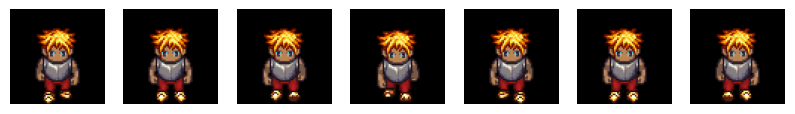

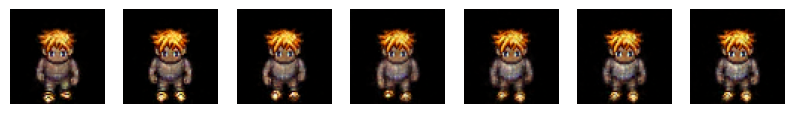

Reconstruction loss: 30.369991302490234


In [55]:
### TESTING RECONSTRUCTION ###
lldm = lldm.to('cuda')
lldm = lldm.eval()
#x = train_data[0].to('cuda').unsqueeze(0)


# z = lldm.encoder(x).embedding[0]
# _, z, _ = lldm.ddim_sampler.sample(shape = (1 , 3, 2, 2), x_last = z.reshape(1,3,2,2), cond = None)


# z = z.reshape(8,  12)
# x_rec = lldm.decoder(z).reconstruction

idx = torch.randint(0, len(train_dataset), (1,)).item()
x = train_dataset[idx]
z_seq, x_rec = lldm.reconstruct(x, vi_index = 6)

x = x.data.unsqueeze(0)
x = x.to(x_rec.device)
plot_sequence(x.data)
plot_sequence(x_rec)

recon_loss = (
                0.5 * (
                    F.mse_loss(
                        x_rec.reshape(x.shape[0]*lldm.n_obs, -1),
                        x.reshape(x.shape[0]*lldm.n_obs, -1),
                        reduction="none"
                    )).sum(dim=-1).reshape(x.shape[0], -1)
            ).mean(dim=-1).item()

print('Reconstruction loss:', recon_loss)


In [56]:
train_embeddings = [] 
log_vars = []

train_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=False)
for i, x in enumerate(train_loader):
    x = x.to('cuda')
    out = lldm.encoder(x)
    z = out.embedding.reshape(-1, 7, 12)
    log_var = out.log_covariance
    train_embeddings.append(z.cpu().detach())
    log_vars.append(log_var.cpu().detach())
train_embeddings = torch.stack(train_embeddings).squeeze(1)
print(train_embeddings.shape)

torch.Size([8000, 7, 12])


In [16]:
log_abs_det_jac_posteriors = []
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=200, shuffle=False)
for i, x in enumerate(train_loader):
    out = lldm(x)
    log_abs_det_jac_posteriors.append(out.log_abs_det_jac_posterior.cpu().detach())
log_abs_det_jac_posteriors = torch.stack(log_abs_det_jac_posteriors).reshape(-1, train_data.shape[0]).squeeze()

PCA on the whole dataset (56000 data points)


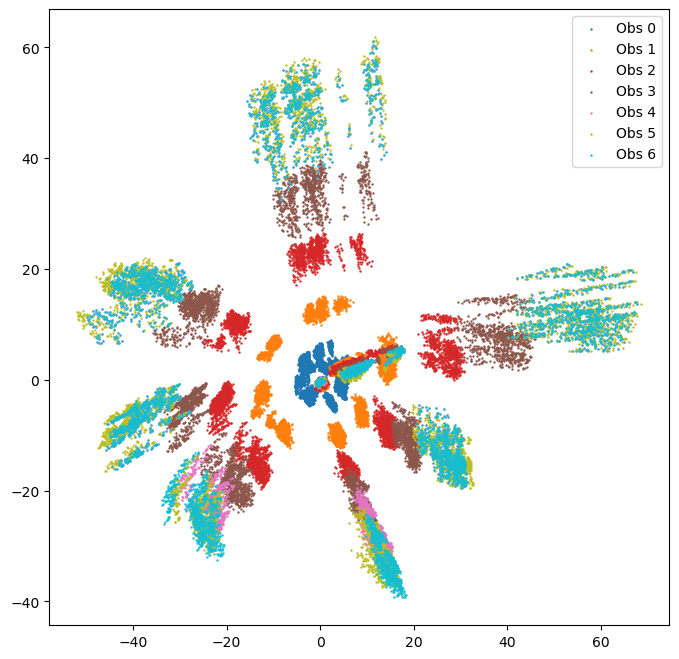

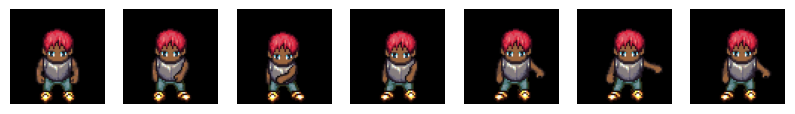

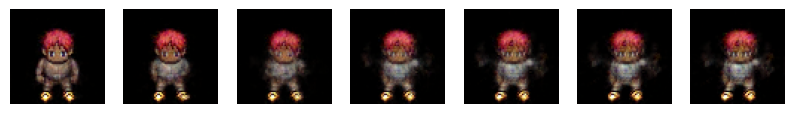

Reconstruction loss: 42.72187805175781


In [57]:
pca = PCA(n_components=2)
num_obs = train_embeddings.shape[1]
#torch.manual_seed(46)

###################
vi_index = 0
projection_index = 'all' # 'all', 'pre
displayed_indexes = range(num_obs)  #range(num_obs)
train_point = 556
##################


if projection_index == 'all':
    gathered = train_embeddings.reshape(-1, latent_dim)
    pca.fit(gathered)
    print(f'PCA on the whole dataset ({gathered.shape[0]} data points)')
elif projection_index == 'pre':
    last_preembed = torch.load('preembedding-last.pt')
    #last_preembed = torch.load('pre-embeddings2.pt')
    pca.fit(last_preembed)
else:
    pca.fit(train_embeddings[:, projection_index, :].reshape(-1, latent_dim))

train_embeddings_pca = []
for i in range(num_obs):
    train_embeddings_pca.append(pca.transform(train_embeddings[:, i, :].reshape(-1, latent_dim)))

train_embeddings_pca = np.stack(train_embeddings_pca).transpose(1, 0, 2)



plt.figure(figsize=(8, 8))
colors = plt.get_cmap('tab10', num_obs)
for i in displayed_indexes:
    plt.scatter(train_embeddings_pca[:, i, 0], train_embeddings_pca[:, i, 1], s=0.5, color=colors(i), label=f'Obs {i}')

x = train_dataset[train_point]

z_seq, x_rec = lldm.reconstruct(x, vi_index = vi_index)

# sampler = lldm.ddim_sampler
# start = train_embeddings[train_point, vi_index, :].cuda().reshape(1, model.c, model.h, model.w)
# _, z_seq, _ = sampler.sample(shape=(1, model.c, model.h, model.w), x_last = start, cond=None)
# z_seq = z_seq[:-1].reshape(-1, latent_dim)
# x_rec = lldm.decoder(z_seq).reconstruction


z_seq_pca = pca.transform(z_seq.cpu().detach())

colors = plt.get_cmap('Spectral', 7)
# for i in range(num_obs):
#     plt.scatter(z_seq_pca[i, 0], z_seq_pca[i, 1], s=20, color=colors(i), label=f'Point {i}')


plt.legend()
plt.show()

x = x.data.unsqueeze(0)
x = x.to(x_rec.device)
plot_sequence(x.data)
plot_sequence(x_rec)

recon_loss = (
                0.5 * (
                    F.mse_loss(
                        x_rec.reshape(x.shape[0]*lldm.n_obs, -1),
                        x.reshape(x.shape[0]*lldm.n_obs, -1),
                        reduction="none"
                    )).sum(dim=-1).reshape(x.shape[0], -1)
            ).mean(dim=-1).item()

print('Reconstruction loss:', recon_loss)


step: 997 index: 6
step: 831 index: 5
step: 665 index: 4
step: 499 index: 3
step: 333 index: 2
step: 167 index: 1
step: 1 index: 0


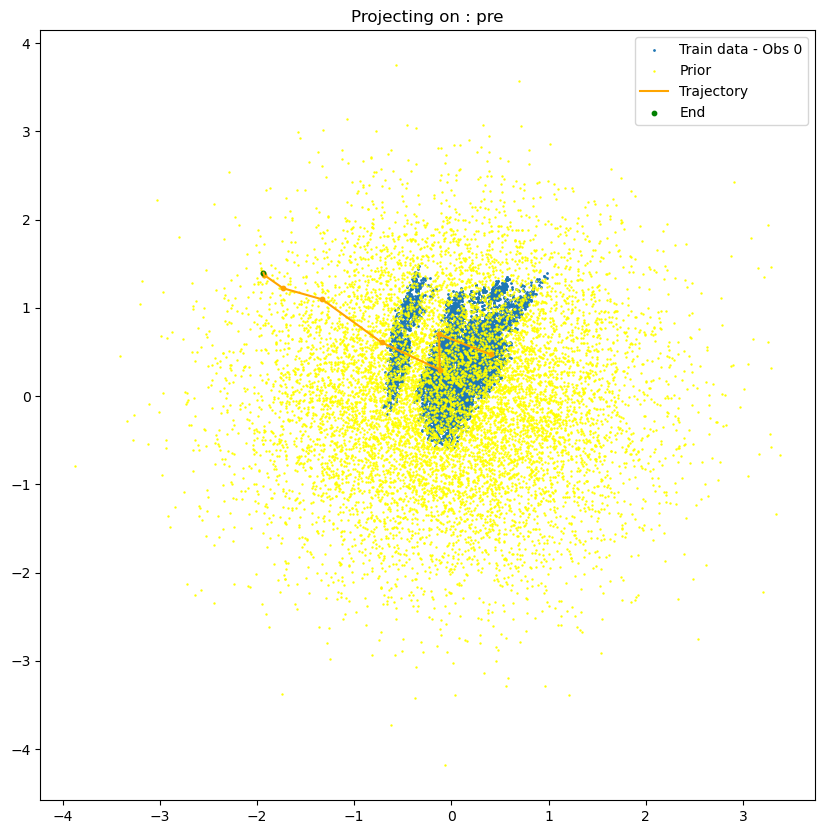

In [56]:
sampler = DDIMSampler(diffusion, n_steps = train_data.shape[1]-1, ddim_eta = 0.5)
lldm = lldm.to('cuda')
lldm.eval()

######################
check_index = 0 #6
start = 'embedding' #'embedding'
######################

assert check_index == 6 or check_index == 0
assert start == 'normal' or start == 'embedding'
if check_index == 0:
    check = np.random.randn(10000, model.lat_dim)
if check_index == 6:
    check = last_preembed


check_pca = pca.transform(check)

if start == 'normal':
    start = torch.randn(1, model.c, model.h, model.w).to('cuda')
if start == 'embedding':
    start = train_embeddings[train_point, 0, :].reshape(1, model.c, model.h, model.w).to('cuda')

z, all_z, all_pred_z0 = sampler.sample(shape=(1, model.c, model.h, model.w), x_last = start, cond=None)

z = z.reshape(-1, latent_dim).float()
x = vae.decoder(z).reconstruction.reshape(-1, 3, 64, 64)


all_z = all_z.squeeze(1).reshape(-1, latent_dim)

all_x = vae.decoder(all_z).reconstruction.reshape(-1, 3, 64, 64)

start = start.reshape(-1, latent_dim).float()



all_z_pca = pca.transform(all_z.detach().cpu().numpy())
start_pca = pca.transform(start.detach().cpu().numpy())
z_pca = pca.transform(z.detach().cpu().numpy())
plt.figure(figsize=(10, 10))
plt.scatter(train_embeddings_pca[:, check_index, 0], train_embeddings_pca[:, check_index, 1], label=f'Train data - Obs {check_index}', s= 1)
plt.scatter(check_pca[:, 0], check_pca[:, 1], label='Prior', s= 0.5, c = 'yellow')


plt.plot(all_z_pca[:, 0], all_z_pca[:, 1], label='Trajectory', c = 'orange')
plt.scatter(all_z_pca[:, 0], all_z_pca[:, 1], c = 'orange', s=10)
plt.scatter(z_pca[:, 0], z_pca[:, 1], s=10, label = "End", c = 'green')
plt.legend()
plt.title('Projecting on : ' + str(projection_index))
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


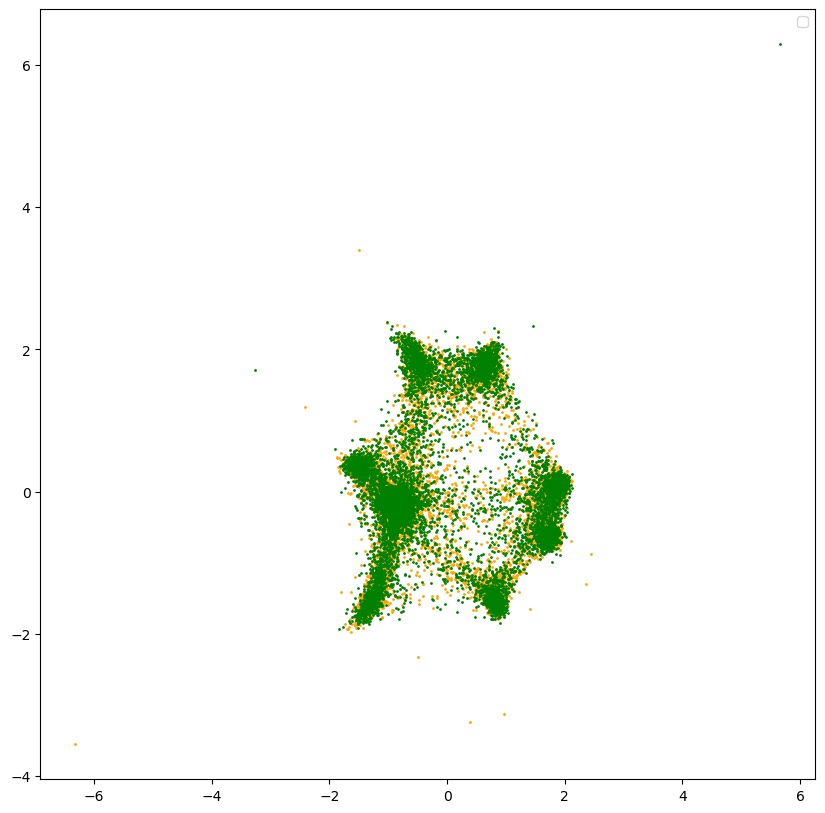

In [33]:
NUM_POINTS = 10000

INDEX = -1

sampler = lldm.ddim_sampler
z = torch.randn(NUM_POINTS, latent_dim).to('cuda')

_, final_z_1, _ = sampler.sample(shape = (NUM_POINTS, 3, 2, 2), x_last = z.reshape(NUM_POINTS, 3, 2, 2), cond = None)
final_z_1  = final_z_1[INDEX, :, :, :, :].reshape(-1, latent_dim)

z_vi_index = z
z_seq = [z_vi_index]

z_for = z_vi_index
batch_size = z_for.shape[0]
vi_index = 0
for i in range(vi_index, lldm.n_obs - 1):
    t = torch.tensor(lldm.diff_t_steps[i]).reshape(1).to(lldm.pretrained_ldm.device).float() #diffusion time-step
    z_for = z_for.reshape(batch_size, lldm.pretrained_ldm.c, lldm.pretrained_ldm.h, lldm.pretrained_ldm.w).float().to(lldm.pretrained_ldm.device)
    noise_pred = lldm.pretrained_ldm(z_for, t) # \eps_\theta (z_t, t)
    z_for, _ = sampler.get_x_prev_and_pred_x0(e_t = noise_pred,
                                                        index = lldm.n_obs -1- i,
                                                        x = z_for,
                                                        temperature=lldm.temperature,
                                                        repeat_noise=False)
    
    z_for = z_for.reshape(batch_size, lldm.pretrained_ldm.c * lldm.pretrained_ldm.h * lldm.pretrained_ldm.w).to(lldm.pretrained_ldm.device)
    z_seq.append(z_for)



z_seq = torch.stack(z_seq, dim = 1)

final_z_2 = z_seq[:, INDEX, :].reshape(-1, latent_dim)

z_pca = pca.transform(z.detach().cpu().numpy())
final_z_pca = pca.transform(final_z_1.detach().cpu().numpy())
final_z_pca_2 = pca.transform(final_z_2.detach().cpu().numpy())

plt.figure(figsize=(10, 10))
#plt.scatter(z_pca[:, 0], z_pca[:, 1], label='Prior', s= 0.5, c = 'yellow')

plt.scatter(final_z_pca[:, 0], final_z_pca[:, 1], c = 'orange', s=1)
plt.scatter(final_z_pca_2[:, 0], final_z_pca_2[: ,1], c = 'green', s=1)
#plt.scatter(check_pca[:, 0], check_pca[:, 1], label='Prior', s= 1, c = 'yellow')
plt.legend()

In [23]:
train_embed_0 = train_embeddings[:, 0, :].reshape(-1, latent_dim)
log_vars_0 = log_vars[:, 0, :].reshape(-1, latent_dim)

z= train_embed_0
z_0_vi_index = z
mu = z
log_var = log_vars_0
log_prior = -(0.5 * torch.pow(z, 2)).sum(dim=1)
#log_prior = - lldm.pretrained_vae.log_pi(z)
log_prob_z_vi_index = (
            -0.5 * (log_var + torch.pow(z_0_vi_index - mu, 2) / (torch.exp(log_var) + 1e-5)) #adding small constant to avoid numerical instability in the denominator
        ).sum(dim=1) 

KLD = log_prob_z_vi_index.cpu() - log_prior.cpu()
KLD = KLD.mean().item()
KLD


18.167098999023438

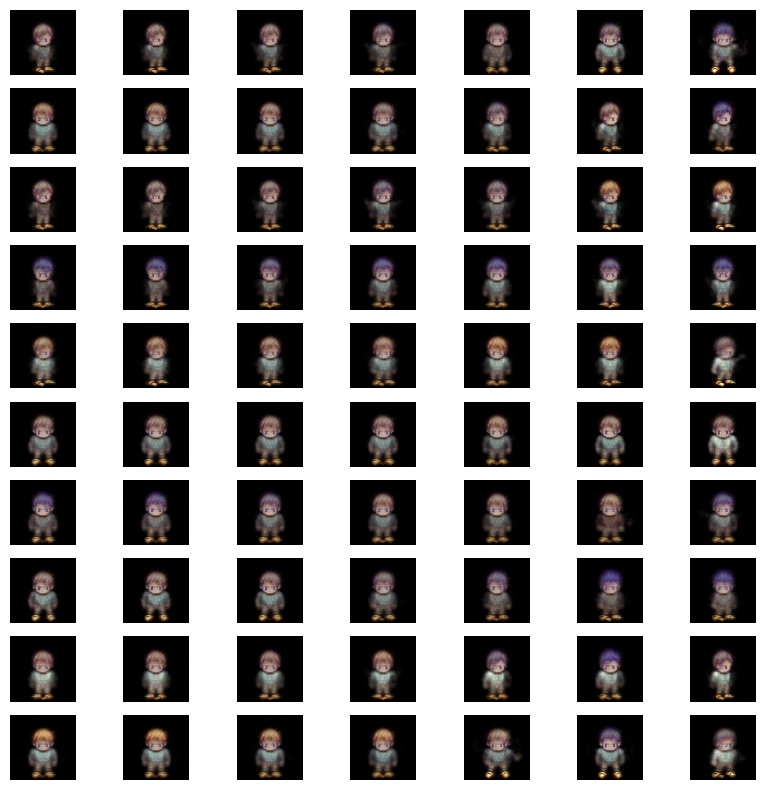

In [39]:
### TESTING GENERATION ###

lldm = lldm.to('cuda')
lldm.device = 'cuda'

lldm = lldm.eval()
recon_x = lldm.generate(10, temperature =1)

plot_sequence(recon_x)

